# EXPLORATORY DATA ANALYSIS
### CHARGEMENT DES DONNéES

In [56]:
import scipy.io
import numpy as np

data_matrix = scipy.io.loadmat("gliome.mat")

print("Data Keys: "     ,data_matrix.keys())
print("__header__: "    ,data_matrix['__header__'])
print("__version__: "   ,data_matrix['__version__'])

X = data_matrix['X']
print("X shape: {}".format(X.shape))

y = data_matrix['Y'][:, 0] 
#y = y.reshape((y.shape[0],1))
print("Y shape: {}".format(y.shape))
print("Classes: ",np.unique(y))

Data Keys:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])
__header__:  b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 17 16:07:27 2015'
__version__:  1.0
X shape: (50, 4434)
Y shape: (50,)
Classes:  [1 2 3 4]


### PCA ANALYSIS -> Choosing 2 features

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Standardizing the features
X_std = StandardScaler().fit_transform(X)

# PCA projection to 2D
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)

(50, 2)


### PCA Analysis -> PLOT

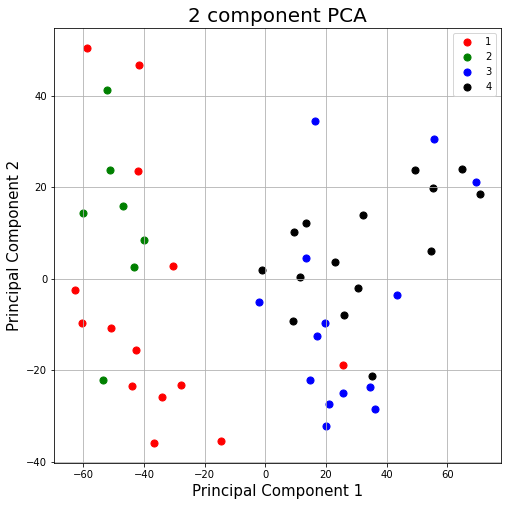

In [69]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1,2,3,4]
colors = ['r', 'g', 'b', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = np.array(np.where(y == target))
    indicesToKeep = indicesToKeep[0,:]
    ax.scatter(principalComponents[indicesToKeep,0]
               , principalComponents[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### PCA Analysis -> Variance Analysis

In [59]:
var_ratio = pca.explained_variance_ratio_
print(var_ratio)
print(np.sum(var_ratio))

[0.3666784  0.10752368]
0.4742020834860426


### Comment: TWO components do not gather enough information about the data. The first component contains 36.66% of the information, and the second component contains 10.75%. The two principal components can not divide the samples in 4 groups. This can be corroborated also by looking the plot.     

### PCA Analysis -> 95% of variance retained 

In [60]:
pca = PCA(.95)
pca.fit_transform(X_std)
var_ratio = pca.explained_variance_ratio_
print("Total Variance", np.sum(var_ratio)*100, "%")
print("Number of Principal Components", pca.n_components_)

Total Variance 95.16273410314479 %
Number of Principal Components 36


### Conclusion: We can reduce the number of features by applying PCA transformation to the data. For example, the initial 4434 features can be reduced to approx 36 features preserving 95% of information of the variance.

# RANDOM FOREST CLASSIFIER
### SPLIT DATA INTO TRAINING AND TEST SETS
### TRAINING AND TESTING

The available data for training and testing our classification model is small (ONLY 50 SAMPLES). Therefore, we will used "Leave One Out Cross Validation". In other words data splitting will not be necessary. The model will be trained with 49 samples and will be validated with one sample.
The accuracy of the model will be described by the mean and standard deviation of all the iterations. 

In [61]:
# loocv to manually evaluate the performance of a random forest classifier
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# create loocv procedure
loocv = LeaveOneOut()
scaler = StandardScaler()

# enumerate splits
y_true, y_pred = list(), list()

for train_ix, test_ix in loocv.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]

	# Fit on training set only
	scaler.fit(X_train)

	# Apply transform to both the training set and the test set.
	X_train = scaler.transform(X_train)
	X_test  = scaler.transform(X_test)

	# Apply PCA
	pca = PCA(0.95)
	pca.fit(X_train)

	# Apply the mapping (transform) to both the training set and the test set
	X_train = pca.transform(X_train)
	X_test  = pca.transform(X_test)
	
	# Fit model

	model = RandomForestClassifier(n_estimators=10, random_state= 0, bootstrap=True)
	model.fit(X_train, y_train)
	
	# Evaluate model
	yhat = model.predict(X_test)
	# store
	y_true.append(y_test[0])
	y_pred.append(yhat[0])


print(metrics.classification_report(y_true = y_true, y_pred = y_pred, digits=4))
print("Average Precision: ",metrics.precision_score(y_true = y_true, y_pred = y_pred, average='macro'))

              precision    recall  f1-score   support

           1     0.8125    0.9286    0.8667        14
           2     1.0000    0.2857    0.4444         7
           3     0.6875    0.7857    0.7333        14
           4     0.6875    0.7333    0.7097        15

    accuracy                         0.7400        50
   macro avg     0.7969    0.6833    0.6885        50
weighted avg     0.7662    0.7400    0.7231        50

Average Precision:  0.796875


# NOTE: We observe many ways to evaluate the Classification Model. In this particular case, we are interested in what proportion of positive identifications was actually correct, therefore we calculate the PRECISION, in particular the AVERAGE PRECISION.

# For RandomForestClassiffier = 0.8

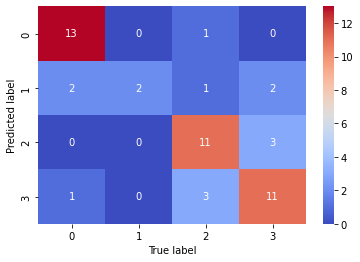

In [62]:
import seaborn as sns
cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
ax = sns.heatmap(cm, cmap='coolwarm', annot=cm)
ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
plt.show()

### NOTE:
### We observed 10 misclassified samples out of 50.
### We train the model using only 36 features which were calculated using PCA
### The best hyperparameter "number of trees" was calculated by try/error 

# LOGISTIC REGRESSION
### SPLIT DATA INTO TRAINING AND TEST SETS
### TRAINING AND TESTING

In the same way as with Random Forest, we will use "Leave One Out Cross Validation" due to the small number of samples. 

In [63]:
# loocv to manually evaluate the performance of a logistic regression
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# create loocv procedure
loocv = LeaveOneOut()
scaler = StandardScaler()

# enumerate splits
y_true, y_pred = list(), list()

C = 20
penalty='l2'

for train_ix, test_ix in loocv.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]

	# Fit on training set only
	scaler.fit(X_train)

	# Apply transform to both the training set and the test set.
	X_train = scaler.transform(X_train)
	X_test  = scaler.transform(X_test)

	# Apply PCA
	pca = PCA(0.95)
	pca.fit(X_train)

	# Apply the mapping (transform) to both the training set and the test set
	X_train = pca.transform(X_train)
	X_test  = pca.transform(X_test)
	
	# Fit model

	model_log = LogisticRegression(C=C, max_iter=500)
	model_log.fit(X_train, y_train)
	
	# Evaluate model
	yhat = model_log.predict(X_test)
	# store
	y_true.append(y_test[0])
	y_pred.append(yhat[0])


print(metrics.classification_report(y_true = y_true, y_pred = y_pred, digits=4))
print("Average Precision: ",metrics.precision_score(y_true = y_true, y_pred = y_pred, average='macro'))

              precision    recall  f1-score   support

           1     0.8125    0.9286    0.8667        14
           2     1.0000    0.5714    0.7273         7
           3     0.8462    0.7857    0.8148        14
           4     0.8235    0.9333    0.8750        15

    accuracy                         0.8400        50
   macro avg     0.8705    0.8048    0.8209        50
weighted avg     0.8515    0.8400    0.8351        50

Average Precision:  0.8705458144796381


## We see an average precision of 0.87

### This shows a that logistic regression has a better performance than the random forest classifier

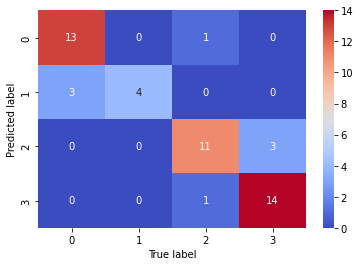

In [64]:
import seaborn as sns
cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
ax = sns.heatmap(cm, cmap='coolwarm', annot=cm)
ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
plt.show()

### From the confusion matrix:
### We observe only 8 misclassified samples out of 50.
### There is an overall high precision and recall, except for the recall when classifying the second class. Both classifiers, random forest and logistic regression have a high precision but low recall in this class.
### With this model we can obtain a better precision and recall than with the random forest.
### The best hyperparameter "C" was obtained by try/error 

# Feature importance based on feature permutation
Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [65]:
# split data
X_train = X
y_train = y

# Fit on training set only
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)

# Apply PCA
pca = PCA(0.95)
pca.fit(X_train)

# Apply the mapping (transform) to both the training set and the test set
X_train = pca.transform(X_train)

# Fit model
forest = RandomForestClassifier(n_estimators=10, random_state= 0, bootstrap=True)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [66]:
from sklearn.inspection import permutation_importance
import pandas as pd

X_train_shape = np.shape(X_train)
feature_names = [f"Imp Feat {i+1}" for i in range(X_train_shape[1])]
result = permutation_importance(forest, X_train, y_train, n_repeats=10, random_state=0, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)  

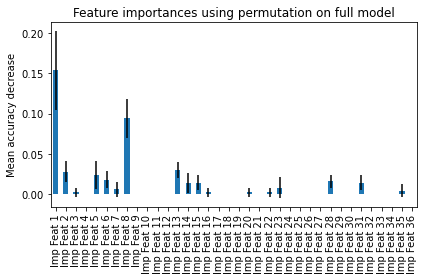

In [67]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## ANALYSIS: We see that the most important features for the model based on Random Forest are: Feature 1,8,13,2,5. However these features represents the transformation that maximizes the variance. Therefore, after using PCA we lost the sense of the real features.  

In [90]:
from operator import itemgetter
# for first binary classification (classes 1 and 2) 
# get importance
importance = abs(model_log.coef_[0])
l = [i for i in range(1,len(importance))]
feat1 = list(zip(l,importance))
feat1.sort(key=itemgetter(1), reverse= True)
print("\n1st binary classification")
for a,b in feat1[:5]:
    print(a,b)

# we do the same for each binary classification and find the most important features in each one

# for the second binary classification
# get importance
importance = abs(model_log.coef_[1])
feat2 = list(zip(l,importance))
feat2.sort(key=itemgetter(1), reverse= True)
print("\n2nd binary classification")
for a,b in feat2[:5]:
    print(a,b)
    
# for the third binary classification
# get importance
importance = abs(model_log.coef_[2])
feat3 = list(zip(l,importance))
feat3.sort(key=itemgetter(1), reverse= True)
print("\n3rd binary classification")
for a,b in feat3[:5]:
    print(a,b)
    
# for thefourth binary classification
# get importance
importance = abs(model_log.coef_[3])
feat4 = list(zip(l,importance))
feat4.sort(key=itemgetter(1), reverse= True)
print("\n4th binary classification")
for a,b in feat4[:5]:
    print(a,b)


1st binary classification
3 0.17929939328551803
5 0.1757801577965714
1 0.14322259587698083
7 0.13771929925145912
9 0.10771524543638758

2nd binary classification
1 0.1893112380343433
7 0.14496140324149917
18 0.097514106001752
15 0.09402735558388899
3 0.09059912101064795

3rd binary classification
8 0.3203176543671906
5 0.2088503231440963
6 0.2004649236689071
1 0.13782484861619082
31 0.13255339916722578

4th binary classification
5 0.30055148914876506
8 0.25722241502079707
1 0.19470898528447214
6 0.18856406985129617
9 0.18583817051920526


### From the given tables we can say that the most important features are features 1,5 and 3
#### Two of this features where also found as the most important for the random forest model.